# Introduction

This is my first work on the time series, so I decided to keep it as simple as possible.
For this reason I chose to use a direct predictions instead of a multi step one and I based the choices on a linear regression.
The main work was done by using a simple function to find the best features for the linear regression to obtain the best fit.
The performances were measured on the total of sales for each shop using mean squared log error, and checking some random plots and the residual plots.
I tested the function by adding one feature at a time and comparing the results: dummy features against Fourier ones and numerical ones. The test was done on periods of: 60, 30, 16 and 6 days. When the performances were stable enough I added a random forest regressor to the model to try to catch what the linear regression couldn't do.
This 'trial and error' approach allowed me to understand when there was a degradation of the performances.
The final model was the average result of linear regression and random forest regressor.

Summary:
- I decided to make the training start on 2016-06-01 because: first, in the early years the patterns are clearly different from the ones in the last years regarding sales and oil; second, I wanted to avoid some peaks during May and April 2016, since I obtained a degradation of the performances when including them; third, I wanted to include the same period of the test.
- I applied a logarithm transformation on the sales in order to fix a problem of linearity showed in the residual plot, probably due to the compound growth.
- I applied an "exponentially weighted cost function" to give more weight to the last year.
- A big improvement came by adding a dummy feature catching the days when shops were closed, when total daily sales were zero. Some shops opened during the period of training, others had a temporary closure, and on the first day of the year all shops were closed.
- Another big improvement came by adding the periods when the schools start. Searching quickly on web I found there were two periods: April-May and August-September. This helped me to catch the seasonality of the sales of school products.

Last notes:
- Using only the linear regression I obtained a score of 0.41469.
- I decided not to include all the plots since the notebook was already heavy enough.   
- I tried using XGBRegressor instead of RandomForestRegressor but the performances were worse.
- I didn't try to tune parameters, even when I tried XGBRegressor, maybe the result could be better.
- I didn't try any other algorithms.
- I would have liked to use onpromotion and transactions but, having used a direct prediction and using a model for each shop, I could't find a way to do it.
- I would have liked to try a GAM algorithm, but I only know pygam and I could't find a method to use it with multi target. Doing a loop for each shop and each product would have been too heavy.

I look forward to receiving any advice to improve my work, or any error reports.
Thanks.

# Loading libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
        
from scipy.stats import skew,norm,zscore
from scipy.signal import periodogram

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, make_scorer, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [3]:
warnings.filterwarnings('ignore')

In [4]:
sns.set_theme()

# Importing the dataset

In [5]:
orig_holidays_events = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv", parse_dates=['date'])
orig_oil = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv", parse_dates=['date'])
orig_stores = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
orig_transactions = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv", parse_dates=['date'])

In [6]:
orig_test = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv", parse_dates=['date'])
orig_train = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv", parse_dates=['date'])

In [7]:
orig_holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [8]:
orig_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [9]:
orig_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [10]:
orig_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [11]:
orig_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [12]:
orig_train.sample(10)

id       date  store_nbr               family     sales  \
1773823  1773823 2015-09-25          3             CLEANING  1847.000   
482678    482678 2013-09-28         51      LAWN AND GARDEN    15.000   
341170    341170 2013-07-11         31  HOME AND KITCHEN II     0.000   
1955090  1955090 2016-01-06         16         BREAD/BAKERY   176.000   
808546    808546 2014-03-31         45           GROCERY II   104.000   
450044    450044 2013-09-10         36            MAGAZINES     0.000   
2676576  2676576 2017-02-15          1            GROCERY I  2740.000   
2267838  2267838 2016-06-29         40            GROCERY I  3761.000   
1487026  1487026 2015-04-17         32           GROCERY II     0.000   
2154975  2154975 2016-04-27         24                 DELI   209.395   

         onpromotion  
1773823            5  
482678             0  
341170             0  
1955090            0  
808546             0  
450044             0  
2676576           51  
2267838           43  
1487026            0  
2154975            0

In [13]:
orig_test.sample(10)

id       date  store_nbr                      family  onpromotion
22459  3023347 2017-08-28         39                  LADIESWEAR            0
6972   3007860 2017-08-19         54                        DELI            6
1532   3002420 2017-08-16         51                    HARDWARE            0
1730   3002618 2017-08-16          8                    HARDWARE            0
7613   3008501 2017-08-20         22                   MAGAZINES            0
13561  3014449 2017-08-23         39  SCHOOL AND OFFICE SUPPLIES            5
10024  3010912 2017-08-21          4               PERSONAL CARE           11
15701  3016589 2017-08-24         49                PET SUPPLIES            0
8707   3009595 2017-08-20         52                     POULTRY            0
1137   3002025 2017-08-16         40          HOME AND KITCHEN I            2

<AxesSubplot:xlabel='date'>

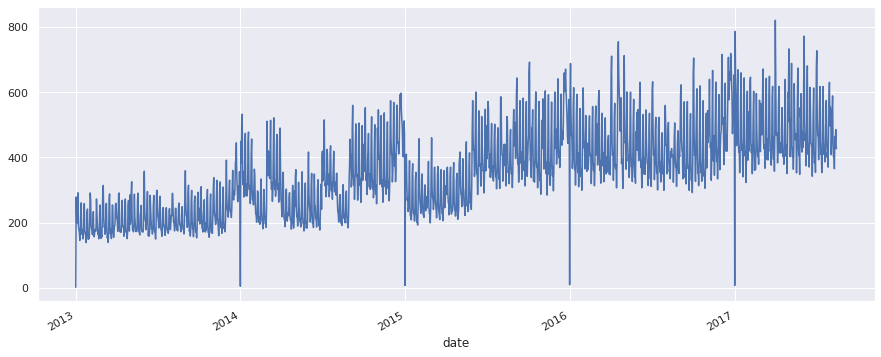

In [14]:
fig = plt.figure(figsize=(15,6))
orig_train.groupby(by='date')['sales'].mean().plot()

# Setting main dates

In [15]:
date = {}

In [16]:
date['date_start_train'] = '2013-01-01'
date['date_end_train'] = '2017-08-15'
date['date_start_test'] = '2017-08-16'
date['date_end_test'] = '2017-08-31'
date['date_start_fore'] = '2016-06-01'

In [17]:

diff_train = (pd.Timestamp(date['date_end_train']) - pd.Timestamp(date['date_start_fore'])).days
diff_test = (pd.Timestamp(date['date_end_test']) - pd.Timestamp(date['date_start_fore'])).days

# Stores

In [18]:
orig_stores.sample(10)

store_nbr           city                           state type  cluster
17         18          Quito                       Pichincha    B       16
26         27          Daule                          Guayas    D        1
40         41        Machala                          El Oro    D        4
0           1          Quito                       Pichincha    D       13
45         46          Quito                       Pichincha    A       14
20         21  Santo Domingo  Santo Domingo de los Tsachilas    B        6
14         15         Ibarra                        Imbabura    C       15
35         36       Libertad                          Guayas    E       10
39         40        Machala                          El Oro    C        3
19         20          Quito                       Pichincha    B        6

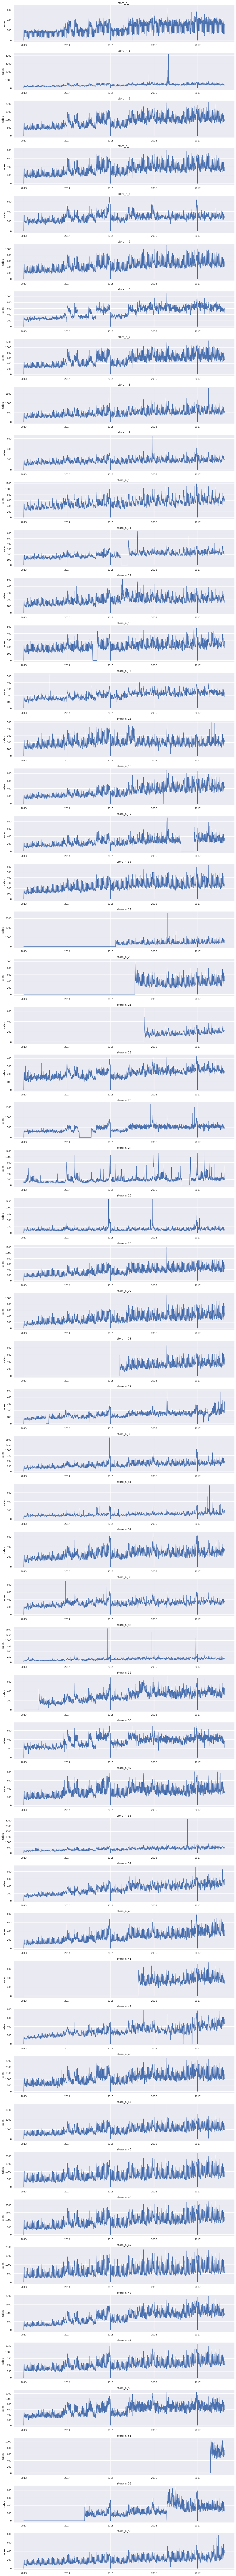

In [19]:
fig, axes = plt.subplots(54, 1, figsize=(15, 54*3))

for ax, i in zip(axes.flat, np.arange(0,54,1)):
    sns.lineplot(ax=axes[i], x=orig_train[orig_train.store_nbr==(i+1)].groupby(by='date')['sales'].mean().reset_index().date.values, y=orig_train[orig_train.store_nbr==(i+1)].groupby(by='date')['sales'].mean())
    ax.set_title(f'store_n_{i}') 
    
fig.tight_layout()

In [20]:
orig_stores.groupby(by=['city']).store_nbr.nunique().sort_values(ascending=False)

city
Quito            18
Guayaquil         8
Santo Domingo     3
Cuenca            3
Manta             2
Machala           2
Latacunga         2
Ambato            2
Guaranda          1
Ibarra            1
Esmeraldas        1
Babahoyo          1
Loja              1
El Carmen         1
Daule             1
Playas            1
Puyo              1
Quevedo           1
Cayambe           1
Riobamba          1
Salinas           1
Libertad          1
Name: store_nbr, dtype: int64

In [21]:
def store_func (orig_df):
    
    df = orig_df.copy()
    
    # Adding features to orig_stores
    df['uniquestore'] = df.city.apply(lambda x: 0 if x in ['Quito', 'Guayaquil', 'Santo Domingo', 'Cuenca', 'Manta', 'Machala', 'Latacunga', 'Ambato'] else 1)
    df['newstore'] = df.store_nbr.apply(lambda x: 1 if x in [19, 20, 21, 28, 35, 41, 51, 52] else 0)
        
    # Merging orig_stores, orig_test and orig_train
    df = pd.concat([orig_train, orig_test], axis=0).merge(df, on=['store_nbr'], how='left')
    df = df.rename(columns={'type' : 'store'}) 

    return df

In [22]:
final_df = store_func(orig_stores)

# Events

In [23]:
orig_holidays_events.sample(10)

date        type    locale locale_name  \
35  2012-12-24      Bridge  National     Ecuador   
143 2014-11-12     Holiday     Local      Ambato   
277 2016-11-04      Bridge  National     Ecuador   
5   2012-05-12     Holiday     Local        Puyo   
189 2015-10-07     Holiday     Local     Quevedo   
209 2015-12-26  Additional  National     Ecuador   
43  2013-01-12    Work Day  National     Ecuador   
73  2013-10-11    Transfer  National     Ecuador   
79  2013-11-11     Holiday     Local   Latacunga   
232 2016-04-28       Event  National     Ecuador   

                             description  transferred  
35                        Puente Navidad        False  
143              Independencia de Ambato        False  
277               Puente Dia de Difuntos        False  
5                 Cantonizacion del Puyo        False  
189             Cantonizacion de Quevedo        False  
209                            Navidad+1        False  
43    Recupero puente primer dia del ano        False  
73   Traslado Independencia de Guayaquil        False  
79            Independencia de Latacunga        False  
232                  Terremoto Manabi+12        False

In [24]:
orig_holidays_events.query("type=='Event'").description.value_counts()

Dia de la Madre                                    5
Mundial de futbol Brasil: Octavos de Final         4
Black Friday                                       3
Cyber Monday                                       3
Mundial de futbol Brasil: Cuartos de Final         2
Mundial de futbol Brasil: Semifinales              2
Terremoto Manabi+21                                1
Terremoto Manabi+14                                1
Terremoto Manabi+15                                1
Terremoto Manabi+16                                1
Terremoto Manabi+17                                1
Terremoto Manabi+18                                1
Terremoto Manabi+19                                1
Terremoto Manabi+20                                1
Terremoto Manabi+24                                1
Terremoto Manabi+22                                1
Terremoto Manabi+23                                1
Terremoto Manabi+12                                1
Terremoto Manabi+25                           

In [25]:
orig_holidays_events[orig_holidays_events[['date', 'locale_name']].duplicated()]

date        type    locale locale_name  \
36  2012-12-24  Additional  National     Ecuador   
40  2012-12-31  Additional  National     Ecuador   
157 2014-12-26  Additional  National     Ecuador   
236 2016-05-01       Event  National     Ecuador   
243 2016-05-07       Event  National     Ecuador   
245 2016-05-08       Event  National     Ecuador   
265 2016-07-24    Transfer     Local   Guayaquil   

                         description  transferred  
36                         Navidad-1        False  
40              Primer dia del ano-1        False  
157                        Navidad+1        False  
236              Terremoto Manabi+15        False  
243              Terremoto Manabi+21        False  
245                  Dia de la Madre        False  
265  Traslado Fundacion de Guayaquil        False

In [26]:
orig_holidays_events.query("date in ('2012-12-24', '2012-12-31', '2014-12-26', '2016-05-01', '2016-05-07', '2016-05-08', '2016-07-24')")

date        type    locale locale_name  \
35  2012-12-24      Bridge  National     Ecuador   
36  2012-12-24  Additional  National     Ecuador   
39  2012-12-31      Bridge  National     Ecuador   
40  2012-12-31  Additional  National     Ecuador   
156 2014-12-26      Bridge  National     Ecuador   
157 2014-12-26  Additional  National     Ecuador   
235 2016-05-01     Holiday  National     Ecuador   
236 2016-05-01       Event  National     Ecuador   
242 2016-05-07  Additional  National     Ecuador   
243 2016-05-07       Event  National     Ecuador   
244 2016-05-08       Event  National     Ecuador   
245 2016-05-08       Event  National     Ecuador   
264 2016-07-24  Additional     Local   Guayaquil   
265 2016-07-24    Transfer     Local   Guayaquil   

                         description  transferred  
35                    Puente Navidad        False  
36                         Navidad-1        False  
39         Puente Primer dia del ano        False  
40              Primer dia del ano-1        False  
156                   Puente Navidad        False  
157                        Navidad+1        False  
235                  Dia del Trabajo        False  
236              Terremoto Manabi+15        False  
242                Dia de la Madre-1        False  
243              Terremoto Manabi+21        False  
244              Terremoto Manabi+22        False  
245                  Dia de la Madre        False  
264         Fundacion de Guayaquil-1        False  
265  Traslado Fundacion de Guayaquil        False

In [27]:
orig_holidays_events.description[orig_holidays_events.description.str.match(r'.*ster.*')]

Series([], Name: description, dtype: object)

In [28]:
orig_train.groupby(by=['store_nbr','date'])['sales'].mean().reset_index().head()

store_nbr       date       sales
0          1 2013-01-01    0.000000
1          1 2013-01-02  224.762061
2          1 2013-01-03  177.977091
3          1 2013-01-04  179.390273
4          1 2013-01-05  191.478334

In [29]:
orig_train.groupby(by=['store_nbr','date'])['sales'].mean().reset_index().query("date.dt.month==1 and date.dt.day==1").sample(10)

store_nbr       date  sales
21665         13 2017-01-01    0.0
55936         34 2014-01-01    0.0
34408         21 2015-01-01    0.0
84564         51 2014-01-01    0.0
23349         14 2017-01-01    0.0
14929          9 2017-01-01    0.0
56300         34 2015-01-01    0.0
4825           3 2017-01-01    0.0
22620         14 2015-01-01    0.0
20572         13 2014-01-01    0.0

In [30]:
orig_holidays_events.query("transferred==True")

date     type    locale locale_name                    description  \
19  2012-10-09  Holiday  National     Ecuador     Independencia de Guayaquil   
72  2013-10-09  Holiday  National     Ecuador     Independencia de Guayaquil   
135 2014-10-09  Holiday  National     Ecuador     Independencia de Guayaquil   
255 2016-05-24  Holiday  National     Ecuador           Batalla de Pichincha   
266 2016-07-25  Holiday     Local   Guayaquil         Fundacion de Guayaquil   
268 2016-08-10  Holiday  National     Ecuador  Primer Grito de Independencia   
297 2017-01-01  Holiday  National     Ecuador             Primer dia del ano   
303 2017-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
312 2017-05-24  Holiday  National     Ecuador           Batalla de Pichincha   
324 2017-08-10  Holiday  National     Ecuador  Primer Grito de Independencia   
328 2017-09-28  Holiday     Local      Ibarra            Fundacion de Ibarra   
340 2017-12-06  Holiday     Local       Quito             Fundacion de Quito   

     transferred  
19          True  
72          True  
135         True  
255         True  
266         True  
268         True  
297         True  
303         True  
312         True  
324         True  
328         True  
340         True

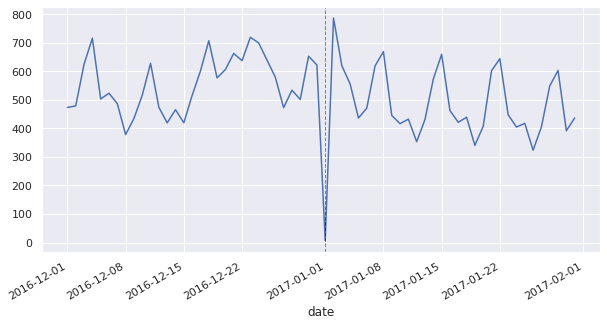

In [31]:
fig = plt.figure(figsize=(10,5))
orig_train.query("(date.dt.year==2017 and date.dt.month==1) or (date.dt.year==2016 and date.dt.month==12)").groupby(by='date')['sales'].mean().plot()
plt.axvline(x=pd.Timestamp('2017-01-01'), color='black', linestyle='--', linewidth=1, alpha=0.5)

In [32]:
orig_holidays_events.query("date.dt.month==1 and date.dt.day==1")

date     type    locale locale_name         description  transferred
41  2013-01-01  Holiday  National     Ecuador  Primer dia del ano        False
92  2014-01-01  Holiday  National     Ecuador  Primer dia del ano        False
159 2015-01-01  Holiday  National     Ecuador  Primer dia del ano        False
211 2016-01-01  Holiday  National     Ecuador  Primer dia del ano        False
297 2017-01-01  Holiday  National     Ecuador  Primer dia del ano         True

In [33]:
def holiday_func (orig_df):
    
    df = orig_df.copy()
    
    # Non-transferred events
    df.loc[297, 'transferred'] = df.loc[297, 'transferred'] = False
    df = df.query("transferred!=True")
    
    # Removing duplicates
    df = df.drop(index=orig_holidays_events[orig_holidays_events[['date', 'locale_name']].duplicated()].index.values)

    # Adding event type
    df.loc[df.type=='Event', 'type'] = df.description.apply(lambda x: x[0:7])
     
    # Merging orig_holidays_events and final_df
    nat_df = df.query("locale=='National'")
    loc_df = df.query("locale=='Local'")
    reg_df = df.query("locale=='Regional'")
    
    df = final_df.merge(nat_df, left_on=['date'], right_on=['date'], how='left')
    df = df.merge(loc_df, left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left')
    df = df.merge(reg_df, left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left')
   
    # Adding New Year
    df['firstday'] = df.description_x.apply(lambda x: 1 if x=='Primer dia del ano' else 0)

    # Matching event and store
    df = df.drop(columns=['locale_x', 'locale_name_x', 'description_x', 'transferred_x',
                          'locale_y', 'locale_name_y', 'description_y', 'transferred_y',
                          'locale', 'locale_name', 'description', 'transferred'])
    df.loc[~df.type_x.isnull(), 'event_type'] = df.type_x.apply(lambda x: x)
    df.loc[~df.type_y.isnull(), 'event_type'] = df.type_y.apply(lambda x: x)
    df.loc[~df.type.isnull(), 'event_type'] = df.type.apply(lambda x: x)
    df.loc[df.event_type.isnull(), 'event_type'] = df.event_type.apply(lambda x: 'norm')
    df = df.drop(columns=['type_x', 'type_y', 'type'])

    df['isevent'] = df.event_type.apply(lambda x: 'y' if x!='norm' else 'n')

    # Adding Easter
    df.loc[df.date.isin(['2017-04-16', '2016-03-27', '2015-04-05', '2014-04-20', '2013-03-31']), 'isevent'] = df.isevent.apply(lambda x: 'y')
    df.loc[df.date.isin(['2017-04-16', '2016-03-27', '2015-04-05', '2014-04-20', '2013-03-31']), 'event_type'] = df.event_type.apply(lambda x: 'Holiday')

    # Adding closure days
    df['isclosed'] = df.groupby(by=['date', 'store_nbr'])['sales'].transform(lambda x: 1 if x.sum()==0 else 0)    
    df.loc[(df.date.dt.year==2017) & (df.date.dt.month==8) & (df.date.dt.day>=16) , 'isclosed'] = df.isclosed.apply(lambda x: 0)    
    df.loc[df.date.isin(['2017-01-01']), 'isevent'] = df.isevent.apply(lambda x: 'n')
  
    return df

In [34]:
final_df = holiday_func(orig_holidays_events)

# Oil

<AxesSubplot:xlabel='date', ylabel='dcoilwtico'>

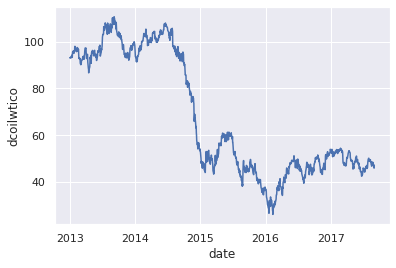

In [35]:
sns.lineplot(y=orig_oil.dcoilwtico, x=orig_oil.date)

In [36]:
orig_oil.set_index('date').resample("D").mean().isnull().sum()

dcoilwtico    529
dtype: int64

In [37]:
def oil_func (orig_df):
    
    df = orig_df.copy()
    
    # Adding missing values
    df = df.set_index('date').resample("D").mean().interpolate(limit_direction='backward').reset_index()
    
    # Adding new features
    df['lagoil_1_dcoilwtico'] = df['dcoilwtico'].shift(1)
    df['lagoil_2_dcoilwtico'] = df['dcoilwtico'].shift(2)
    df['lagoil_3_dcoilwtico'] = df['dcoilwtico'].shift(3)
    df['lagoil_4_dcoilwtico'] = df['dcoilwtico'].shift(4)
    df['oil_week_avg'] = df['dcoilwtico'].rolling(7).mean()

    df.dropna(inplace = True)
    
    # Merging orig_oil and final_df
    df = final_df.merge(df, on=['date'], how='left')
    
    return df

In [38]:
final_df = oil_func(orig_oil)

# Transactions

In [39]:
orig_transactions.sample(10)

date  store_nbr  transactions
58171 2016-04-22          8          2978
71659 2017-01-07          3          3813
81872 2017-07-17          5          1311
28636 2014-09-09         13           926
71598 2017-01-05         48          2707
29077 2014-09-18         27          1161
26226 2014-07-20         11          2169
31645 2014-11-10         54           843
38074 2015-03-25         50          2139
70853 2016-12-20         46          4844

In [40]:
def transactions_func (orig_df):
    
    df = orig_df.copy()
    
    # Merging orig_transactions and final_df
    df = final_df.merge(df, on=['date', 'store_nbr'], how='left')
    
    # Filling missing values
    df.loc[(df.transactions.isnull()) & (df.isclosed==1), 'transactions'] = df.transactions.apply(lambda x: 0)
    group_df = df.groupby(by=['store_nbr', 'date']).transactions.first().reset_index()
    group_df['avg_tra'] = group_df.transactions.rolling(15, min_periods=10).mean()
    group_df.drop(columns='transactions', inplace=True)
    df = df.merge(group_df, on=['date', 'store_nbr'], how='left')
    df.loc[(df.transactions.isnull()) & (df.isclosed==0), 'transactions'] = df.avg_tra
    df.drop(columns='avg_tra', inplace=True)
    df.loc[(df.date.dt.year==2017) & (df.date.dt.month==8) & (df.date.dt.day>=16) , 'transactions'] = df.transactions.apply(lambda x: None)    

    df['tot_store_day_onprom'] = df.groupby(by=['date', 'store_nbr']).onpromotion.transform(lambda x: x.sum())

    return df

In [41]:
final_df = transactions_func(orig_transactions)

<AxesSubplot:xlabel='date'>

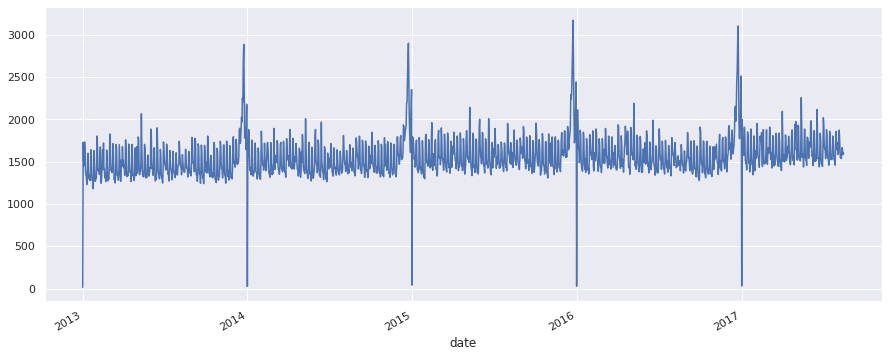

In [42]:
fig = plt.figure(figsize=(15,6))
final_df.groupby(by='date')['transactions'].mean().plot()

In [43]:
del orig_train
del orig_test
del orig_stores
del orig_holidays_events
del orig_oil
del orig_transactions

# Final dataframe

In [44]:
final_df.sample(10)

id       date  store_nbr                   family    sales  \
1349856  1349856 2015-01-30         33                    MEATS  177.591   
854424    854424 2014-04-26         32                 LINGERIE    2.000   
242669    242669 2013-05-17         18          LAWN AND GARDEN    0.000   
1275967  1275967 2014-12-19         10         LIQUOR,WINE,BEER   41.000   
3016128  3016128 2017-08-24         36  PLAYERS AND ELECTRONICS      NaN   
2033815  2033815 2016-02-19         24            PERSONAL CARE  241.000   
698727    698727 2014-01-29         14                HOME CARE  213.000   
423903    423903 2013-08-26         52                HOME CARE    0.000   
2832356  2832356 2017-05-13          3                  SEAFOOD  125.200   
1586389  1586389 2015-06-12         20               GROCERY II   21.000   

         onpromotion       city       state store  cluster  ...  isevent  \
1349856            0    Quevedo    Los Rios     C        3  ...        n   
854424             0  Guayaquil      Guayas     C        3  ...        n   
242669             0      Quito   Pichincha     B       16  ...        n   
1275967            0      Quito   Pichincha     C       15  ...        n   
3016128            0   Libertad      Guayas     E       10  ...        n   
2033815            1  Guayaquil      Guayas     D        1  ...        n   
698727             0   Riobamba  Chimborazo     C        7  ...        n   
423903             0      Manta      Manabi     A       11  ...        n   
2832356            1      Quito   Pichincha     D        8  ...        y   
1586389            0      Quito   Pichincha     B        6  ...        n   

         isclosed  dcoilwtico lagoil_1_dcoilwtico lagoil_2_dcoilwtico  \
1349856         0   47.790000               44.12               44.08   
854424          0  100.943333              100.85              102.20   
242669          0   95.720000               94.85               93.95   
1275967         0   56.910000               54.18               56.43   
3016128         0   47.240000               48.45               47.65   
2033815         0   29.590000               30.77               30.68   
698727          0   97.340000               97.49               95.82   
423903          1  105.880000              106.08              106.28   
2832356         0   48.173333               47.83               47.81   
1586389         0   59.960000               60.74               61.36   

         lagoil_3_dcoilwtico  lagoil_4_dcoilwtico  oil_week_avg  transactions  \
1349856                45.84              44.8000     45.241429         937.0   
854424                101.47             101.6900    102.264048         679.0   
242669                 93.96              94.7600     94.830000        1231.0   
1275967                55.97              55.9600     56.174286        1101.0   
3016128                47.39              47.7900     47.900000          None   
2033815                29.05              29.1175     29.663571        2466.0   
698727                 96.10              96.3800     96.717143        1226.0   
423903                106.48             104.9300    105.497143           0.0   
2832356                47.28              45.8400     47.110952        4340.0   
1586389                60.15              58.1500     59.660000        1373.0   

         tot_store_day_onprom  
1349856                    10  
854424                      0  
242669                      0  
1275967                    24  
3016128                   157  
2033815                   225  
698727                      0  
423903                      0  
2832356                   232  
1586389                    84  

[10 rows x 24 columns]

In [45]:
final_df = final_df.set_index('date').loc[date['date_start_fore']:,:]

In [46]:
final_df.isnull().sum()

id                          0
store_nbr                   0
family                      0
sales                   28512
onpromotion                 0
city                        0
state                       0
store                       0
cluster                     0
uniquestore                 0
newstore                    0
firstday                    0
event_type                  0
isevent                     0
isclosed                    0
dcoilwtico                  0
lagoil_1_dcoilwtico         0
lagoil_2_dcoilwtico         0
lagoil_3_dcoilwtico         0
lagoil_4_dcoilwtico         0
oil_week_avg                0
transactions            28512
tot_store_day_onprom        0
dtype: int64

In [47]:
final_df.groupby(by=['city']).sales.sum().sort_values(ascending=False)

city
Quito            1.850662e+08
Guayaquil        4.155775e+07
Cuenca           1.876670e+07
Ambato           1.281856e+07
Santo Domingo    1.269997e+07
Machala          1.196877e+07
Cayambe          8.777466e+06
Manta            8.358425e+06
Daule            6.602861e+06
Latacunga        6.398649e+06
Babahoyo         5.761306e+06
Esmeraldas       5.670225e+06
Loja             5.594267e+06
Libertad         5.262370e+06
Quevedo          4.214665e+06
Guaranda         4.016079e+06
El Carmen        3.845282e+06
Ibarra           3.554110e+06
Riobamba         3.546952e+06
Salinas          3.400954e+06
Puyo             2.750583e+06
Playas           2.440016e+06
Name: sales, dtype: float64

In [48]:
final_df.query("city=='Quito'").groupby(by=['store_nbr']).sales.sum().sort_values(ascending=False)

store_nbr
44    2.010697e+07
45    1.818568e+07
47    1.692969e+07
3     1.666236e+07
49    1.590922e+07
46    1.338731e+07
48    1.125256e+07
8     1.004547e+07
7     9.107902e+06
9     8.298435e+06
6     8.061466e+06
2     6.845936e+06
20    6.756991e+06
17    6.443996e+06
4     6.017441e+06
1     4.651113e+06
18    3.621918e+06
10    2.781731e+06
Name: sales, dtype: float64

In [49]:
final_df.groupby(by='store').cluster.nunique()

store
A    4
B    3
C    4
D    7
E    1
Name: cluster, dtype: int64

In [50]:
final_df.groupby(by=['store']).sales.sum().sort_values(ascending=False)

store
A    1.180273e+08
D    1.179447e+08
C    5.380120e+07
B    5.065891e+07
E    2.264005e+07
Name: sales, dtype: float64

In [51]:
final_df.groupby(by=['cluster']).sales.sum().sort_values(ascending=False)

cluster
14    5.076277e+07
6     4.127568e+07
11    3.679107e+07
8     3.581573e+07
10    3.064024e+07
13    2.522077e+07
3     2.430911e+07
5     2.010697e+07
1     1.787748e+07
15    1.675057e+07
4     1.543991e+07
2     1.170915e+07
17    1.036647e+07
9     9.642782e+06
12    6.443996e+06
7     6.297535e+06
16    3.621918e+06
Name: sales, dtype: float64

In [52]:
final_df.groupby(by=['family']).sales.sum().sort_values(ascending=False)

family
GROCERY I                     1.076903e+08
BEVERAGES                     7.980141e+07
PRODUCE                       5.471677e+07
CLEANING                      2.868959e+07
DAIRY                         2.145715e+07
BREAD/BAKERY                  1.292329e+07
POULTRY                       9.196818e+06
MEATS                         8.696725e+06
PERSONAL CARE                 7.498256e+06
DELI                          7.272648e+06
HOME CARE                     7.039159e+06
EGGS                          4.605960e+06
FROZEN FOODS                  4.059254e+06
PREPARED FOODS                2.431409e+06
LIQUOR,WINE,BEER              2.312182e+06
HOME AND KITCHEN I            7.806920e+05
HOME AND KITCHEN II           6.555480e+05
GROCERY II                    5.559580e+05
SEAFOOD                       5.341888e+05
CELEBRATION                   3.304340e+05
LAWN AND GARDEN               2.829960e+05
LADIESWEAR                    2.761220e+05
PLAYERS AND ELECTRONICS       2.626510e+05
PET 

In [53]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", 
                        "Bimonthly (6)", "Monthly (12)", "Biweekly (26)", 
                        "Weekly (52)", "Semiweekly (104)"], rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    
    return ax

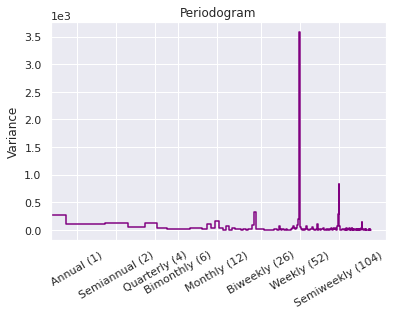

In [54]:
_ = plot_periodogram(final_df.loc['2015-01-01':'2017-08-15'].groupby(by='date').sales.mean())

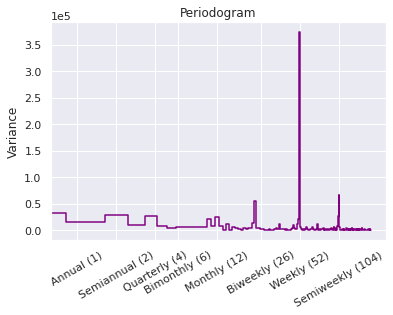

In [55]:
_ = plot_periodogram(final_df.query("family=='GROCERY I'").loc['2015-01-01':'2017-08-15'].groupby(by='date').sales.mean())

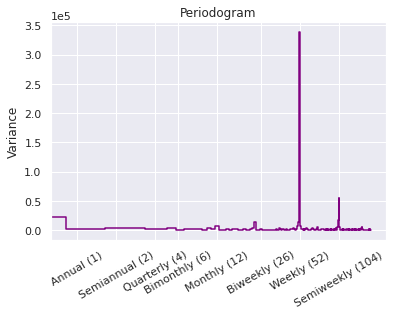

In [56]:
_ = plot_periodogram(final_df.query("family=='BEVERAGES'").loc['2015-01-01':'2017-08-15'].groupby(by='date').sales.mean())

# The model

In [57]:
def split_func (orig_df, X, y, end_date, test_size):
    
    # Splitting train and test
    idx_train, idx_test = train_test_split(orig_df.index, test_size=test_size, shuffle=False)
    X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
    y_train, y_test = y.loc[idx_train], y.loc[idx_test]
    
    return X_train, y_train, X_test, y_test

In [58]:
def add_features (orig_df):
    
    df = orig_df.copy()
        
    # Time features
    df['year'] = df.index.year.astype('int')
    df['quarter'] = df.index.quarter.astype('int')
    df['month'] = df.index.month.astype('int')
    df['day'] = df.index.day.astype('int')
    df['dayofweek'] = df.index.day_of_week.astype('int')
    df['weekofyear'] = df.index.week.astype('int')
    df['isweekend'] = df.dayofweek.apply(lambda x: 1 if x in (5,6) else 0)
    df['startschool'] = df.month.apply(lambda x: 1 if x in (4,5,8,9) else 0)
    
    df['daysinmonth'] = df.index.days_in_month.astype('int')

    # Dummy features
    df = pd.get_dummies(df, columns=['year'], drop_first=True)
    df = pd.get_dummies(df, columns=['quarter'], drop_first=True)
    df = pd.get_dummies(df, columns=['dayofweek'], drop_first=True)
    df = pd.get_dummies(df, columns=['store'], drop_first=True)
    df = pd.get_dummies(df, columns=['event_type'], drop_first=True)
    df = pd.get_dummies(df, columns=['isevent'], drop_first=True)
    df = pd.get_dummies(df, columns=['state'], drop_first=True)

    # DeterministicProcess
    fourierA = CalendarFourier(freq='A', order=5)
    fourierM = CalendarFourier(freq='M', order=2)
    fourierW = CalendarFourier(freq='W', order=4)

    dp = DeterministicProcess(index=df.index,
                          order=1,
                          seasonal=False,
                          constant=False,
                          additional_terms=[fourierA, fourierM, fourierW],
                          drop=True)
    dp_df = dp.in_sample()
    df = pd.concat([df, dp_df], axis=1)
    
    # Outliers
    df['outliers'] = df.sales.apply(lambda x: 1 if x>30000 else 0)
    
    df.drop(columns=['daysinmonth', 'month', 'city'], inplace=True)
    
    return df

In [59]:
def model_func (orig_df, end_df, n):
    
    df = add_features(orig_df).loc[:end_df,:].reset_index().set_index(['store_nbr', 'family', 'date']).sort_index()
    y = np.log1p(df.loc[:,'sales'].unstack(['store_nbr', 'family']))
    
    # Selecting features
    cols = df.columns[df.columns.str.match(r'year|quarter|event|isevent|isclosed|oil\_week|dcoilwtico|week|isweek|startschool|sin|cos|trend')]
    X = df.loc[:,cols]
    X = X.groupby(by='date').first()
    
    X_tr, y_tr, X_te, y_te = split_func(y, X, y, end_df, n)
    
    # Train
    if end_df <= date['date_end_train']:
        y_tr = np.empty((diff_train-n,0))
        y_te = np.empty((n,0))
        pred_train_y = np.empty((diff_train-n,0))
        pred_test_y = np.empty((n,0))
    # Test
    else:
        y_tr = np.empty((diff_test-n,0))
        y_te = np.empty((n,0))
        pred_train_y = np.empty((diff_test-n,0))
        pred_test_y = np.empty((n,0))
    
    # A model for each shop
    for i in orig_df.store_nbr.unique():
        y = df.loc[i,'sales'].unstack(['family'])
        X = df.loc[i,cols]
        X = X.groupby(by='date').first()

        # Splitting train and test and log transformation
        X_train, y_train, X_test, y_test = split_func(y, X, np.log1p(y), end_df, n)
                
        # Exponentially weighted cost function
        weights = X_train.year_2017.apply(lambda x: np.exp((-0.9)*1) if x == 0 else np.exp((-0.9)*0)) 
        
        # Linear regression
        model = LinearRegression()
        model.fit(X_train, y_train, sample_weight=weights)
        lr_pred_train_y = model.predict(X_train) 
        lr_pred_test_y = model.predict(X_test)
        
        # Random Forest
        model = RandomForestRegressor(n_estimators=320, random_state=0)
        model.fit(X_train, y_train, sample_weight=weights)
        rf_pred_train_y = model.predict(X_train) 
        rf_pred_test_y = model.predict(X_test)
        
        # Average result
        st_pred_train_y = lr_pred_train_y * 0.5 + rf_pred_train_y * 0.5
        st_pred_test_y = lr_pred_test_y * 0.5 + rf_pred_test_y * 0.5
        
        y_tr = np.append(y_tr, y_train, axis=1)
        y_te = np.append(y_te, y_test, axis=1)
        pred_train_y = np.append(pred_train_y, st_pred_train_y, axis=1)
        pred_test_y = np.append(pred_test_y, st_pred_test_y, axis=1)
        
        # Performances of each shop
        # Train
        if end_df <= date['date_end_train']:
            print(f'RMSLE_train st_n {i}: ', np.round(np.sqrt(mean_squared_error(y_train.clip(0.0), st_pred_train_y.clip(0.0))), 4), f'RMSLE_test st_n {i}: ', np.round(np.sqrt(mean_squared_error(y_test.clip(0.0), st_pred_test_y.clip(0.0))), 4))
        # Test
        else:
            print(f'RMSLE_train st_n {i}: ', np.round(np.sqrt(mean_squared_error(y_train.clip(0.0), st_pred_train_y.clip(0.0))), 4))
        
    iterables = [final_df.store_nbr.unique(), final_df.family.sort_values().unique()]
    index = pd.MultiIndex.from_product(iterables, names=['store_nbr', 'family'])
    
    y_tr = pd.DataFrame(y_tr, columns=index, index=X_tr.index)
    y_te = pd.DataFrame(y_te, columns=index, index=X_te.index)
    pred_train_y = pd.DataFrame(pred_train_y, columns=y_tr.columns, index=y_tr.index)
    pred_test_y = pd.DataFrame(pred_test_y, columns=y_te.columns, index=y_te.index)
    
    # Total performances
    # Train
    if end_df <= date['date_end_train']:
        print(f'RMSLE_train tot: ', np.round(np.sqrt(mean_squared_error(y_tr.clip(0.0), pred_train_y.clip(0.0))), 4), f'RMSLE_test tot: ', np.round(np.sqrt(mean_squared_error(y_te.clip(0.0), pred_test_y.clip(0.0))), 4))
    # Test
    else:
        print(f'RMSLE_train tot: ', np.round(np.sqrt(mean_squared_error(y_tr.clip(0.0), pred_train_y.clip(0.0))), 4)) 
   
    y_tr = y_tr.stack(['store_nbr', 'family'])
    y_te = y_te.stack(['store_nbr', 'family'])
    y = pd.concat([y_tr, y_te])
    
    pred_train_y = pred_train_y.stack(['store_nbr', 'family'])
    pred_test_y = pred_test_y.stack(['store_nbr', 'family'])
    # If sales < 0 -> 0
    pred_y = pd.concat([pd.Series(pred_train_y).apply(lambda x: 0 if x<0 else x), pd.Series(pred_test_y).apply(lambda x: 0 if x<0 else x)])
    
    # Train
    if end_df <= date['date_end_train']:

        # Some plots to check 
        fig, axes = plt.subplots(4, 2, figsize=(15,10))
        y.loc['2017-02':,:].reset_index().groupby(by='date')[0].sum().plot(ax=axes[0,0], color="red")
        pred_y.loc['2017-02':,:].reset_index().groupby(by='date')[0].sum().plot(ax=axes[0,0], color="orange")
    
        y.loc['2017-08':,:].reset_index().groupby(by='date')[0].sum().plot(ax=axes[0,1], color="red")
        pred_y.loc['2017-08':,:].reset_index().groupby(by='date')[0].sum().plot(ax=axes[0,1], color="orange")
    
        y.loc['2017-02':,:].reset_index().query("family=='GROCERY I'").groupby(by='date')[0].sum().plot(ax=axes[1,0], color="red")
        pred_y.loc['2017-02':,:].reset_index().query("family=='GROCERY I'").groupby(by='date')[0].sum().plot(ax=axes[1,0], color="orange")
    
        y.loc['2017-02':,:].reset_index().query("family=='SCHOOL AND OFFICE SUPPLIES'").groupby(by='date')[0].sum().plot(ax=axes[1,1], color="red")
        pred_y.loc['2017-02':,:].reset_index().query("family=='SCHOOL AND OFFICE SUPPLIES'").groupby(by='date')[0].sum().plot(ax=axes[1,1], color="orange")
    
        (y.loc['2017-02':,:].reset_index().groupby(by='date')[0].sum() - pred_y.loc['2017-02':,:].reset_index().groupby(by='date')[0].sum()).plot(ax=axes[2,1])
        sns.residplot(ax=axes[2,0], x=pred_y.loc['2017-02':,:].reset_index().groupby(by='date')[0].sum(), y=zscore(y.loc['2017-02':,:].reset_index().groupby(by='date')[0].sum() - pred_y.loc['2017-02':,:].reset_index().groupby(by='date')[0].sum()), lowess=True, scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
        y.loc['2017-02':,:].reset_index().query("store_nbr==50").groupby(by='date')[0].sum().plot(ax=axes[3,0], color="red")
        pred_y.loc['2017-02':,:].reset_index().query("store_nbr==50").groupby(by='date')[0].sum().plot(ax=axes[3,0], color="orange")
    
        y.loc['2017-02':,:].reset_index().query("store_nbr==47").groupby(by='date')[0].sum().plot(ax=axes[3,1], color="red")
        pred_y.loc['2017-02':,:].reset_index().query("store_nbr==47").groupby(by='date')[0].sum().plot(ax=axes[3,1], color="orange")
        
        fig.tight_layout()
    # Test
    else:
        return pred_test_y, pred_y, y, df

In [60]:
#model_func(final_df, date['date_end_train'], 60)

In [61]:
#model_func(final_df, date['date_end_train'], 30)

In [62]:
#model_func(final_df, date['date_end_train'], 16)

In [63]:
#model_func(final_df, date['date_end_train'], 6)

In [64]:
model_pred_test_y, model_pred_tot_y, orig_y, final_df = model_func(final_df, date['date_end_test'], 16)

RMSLE_train st_n 1:  0.2466
RMSLE_train st_n 10:  0.2741
RMSLE_train st_n 11:  0.2653
RMSLE_train st_n 12:  0.2661
RMSLE_train st_n 13:  0.2809
RMSLE_train st_n 14:  0.2667
RMSLE_train st_n 15:  0.2719
RMSLE_train st_n 16:  0.2679
RMSLE_train st_n 17:  0.2567
RMSLE_train st_n 18:  0.2378
RMSLE_train st_n 19:  0.2808
RMSLE_train st_n 2:  0.2352
RMSLE_train st_n 20:  0.2736
RMSLE_train st_n 21:  0.2778
RMSLE_train st_n 22:  0.271
RMSLE_train st_n 23:  0.2578
RMSLE_train st_n 24:  0.234
RMSLE_train st_n 25:  0.2663
RMSLE_train st_n 26:  0.297
RMSLE_train st_n 27:  0.2473
RMSLE_train st_n 28:  0.2732
RMSLE_train st_n 29:  0.265
RMSLE_train st_n 3:  0.2144
RMSLE_train st_n 30:  0.2812
RMSLE_train st_n 31:  0.2765
RMSLE_train st_n 32:  0.2845
RMSLE_train st_n 33:  0.2739
RMSLE_train st_n 34:  0.2748
RMSLE_train st_n 35:  0.2705
RMSLE_train st_n 36:  0.2784
RMSLE_train st_n 37:  0.2397
RMSLE_train st_n 38:  0.2441
RMSLE_train st_n 39:  0.2707
RMSLE_train st_n 4:  0.2402
RMSLE_train st_n 40:  

# Final result

In [65]:
y = pd.Series(np.exp(model_pred_tot_y.values) - 1, index=model_pred_tot_y.index)

In [66]:
sub = final_df.reset_index().set_index(['date', 'store_nbr', 'family']).sort_index().loc[date['date_start_fore']:, 'id']

In [67]:
fin_sub = pd.concat([sub, y], axis=1)

In [68]:
fin_sub = fin_sub.rename(columns={0:'sales'})

In [69]:
fin_sub['sales'] = fin_sub['sales'].apply(lambda x: 0 if x<0 else x) 

In [70]:
fin_sub = fin_sub.loc['2017-08-16':]

In [71]:
fin_sub

id        sales
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888     3.590533
                     BABY CARE                   3000889     0.000000
                     BEAUTY                      3000890     3.628726
                     BEVERAGES                   3000891  2334.678926
                     BOOKS                       3000892     0.278358
...                                                  ...          ...
2017-08-31 54        POULTRY                     3029263    52.585813
                     PREPARED FOODS              3029264    74.447744
                     PRODUCE                     3029265   526.304179
                     SCHOOL AND OFFICE SUPPLIES  3029266     0.023832
                     SEAFOOD                     3029267     1.589549

[28512 rows x 2 columns]

# Submission

In [72]:
fin_sub.to_csv('submission.csv', index=False)